### Identify locations of downsampled points and make plot(bar and 3d)

Input: 
Output directory that also contains the corresponding points, endings, and atlas

Origional converted and resampled points


Outputs:
2 excel file (dendrite and axon) for regions with total points count and ending points count

1 html bar plot

1 html 3D scatter plot

In [318]:
import os

import pandas as pd

import numpy as np

import SimpleITK as sitk

import warnings

import tkinter.filedialog as fdialog

import skimage
from skimage import io

import random

import matplotlib.pyplot as plt
import seaborn as sns

import re

import plotly
import plotly.offline
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [263]:
outdir = fdialog.askdirectory(title='Please select the output directory')
m=re.search('\D{2}[0-9]{3}', outdir)
name=m[0]

In [265]:
atlas_name=outdir+'/ara2sample_atlas/result.mhd'
atlas= sitk.ReadImage(atlas_name)
atlas_labels=pd.read_csv('D:\Allenbrainatlas\ARA_25_micron_mhd_ccf2017\labels.csv')

In [266]:
files= os.listdir(outdir)
points=[i for i in files if 'Stepsize' in i]
dendrite= [i for i in points if name+'D' in i]
axon= [i for i in points if name+'D' not in i]

In [267]:
endings= [i for i in files if '_endings' in i]
dendrite_ending= [i for i in endings if name+'D' in i]
axon_ending= [i for i in endings if name+'D' not in i]

In [287]:
def make_pd(all_points, ending_indices):
    ''' 
    Reads in all points as well as ending indices and formulates a pd structure.
    Input: all downsampled points (in transformix compatible format), corresponding indicies of endings 
    ouputs: a pandas dataframe with anatomical regions and their corresponding total points count and ending points count
    
    '''
    ending_indices = np.genfromtxt(ending_indices, delimiter=',', dtype='int')
    
    output=open(all_points,'r')
    outputpoint= output.readlines()
    all_points=[]
    for lines in outputpoint[2:]:
        this_line= lines.split (' ')
        mypoints= [int(stuff) for stuff in this_line]
        all_points.append(mypoints)
        
    points_in_atlas=[int(atlas[i]) for i in all_points ]
    #find an ID for all points
    endings_in_atlas=[points_in_atlas[i] for i in ending_indices]
    # find the IDs associated with endings

    unique_id=set(points_in_atlas)

    our_regions=atlas_labels.loc[atlas_labels['id'].isin (unique_id)]

    id_withcounts=[]
    for i in unique_id:
        id_withcounts.append([i, points_in_atlas.count(i), endings_in_atlas.count(i)])

    new_df= pd.DataFrame(id_withcounts, columns=['id', 'Total_counts','Endings_counts'])
    our_regionWcounts=pd.merge(atlas_labels, new_df)
    return our_regionWcounts.sort_values(by=['Total_counts']), points_in_atlas

In [282]:
def plot_hist(pd_axon, pd_dendrite, outdir, mousename):
    ''' 
    Plot horizontal histogram of all points and ending points of axons and dendrites
    Input: pandas dataframe of axon, pandas dataframe of dendrite, output directory, and mousename
    '''
    y=pd_axon['acronym']
    fig = make_subplots(
        shared_yaxes=True,
        rows=2, cols=2,
        row_heights=[0.9, 0.1],
        column_titles=['Length (um)','# of endings'], 
        row_titles=['Axons', 'Dendrites'],
    )
    fig.add_trace(
        go.Bar(
        y=y, x=pd_axon['Total_counts'], 
        marker_color='olive',
        name='',
        text=pd_axon['name'],
        hovertemplate=
            '<i>%{x}</i>, '+
            '<b>%{text}</b>',
        orientation='h'),
        row=1,col=1
    )
    fig.add_trace(
        go.Bar(
        y=y, x=pd_axon['Endings_counts'],
        marker_color='seagreen',
        name='',
        text=pd_axon['name'],
        hovertemplate=
        '<i>%{x}</i>, '+
        '<b>%{text}</b>',
        orientation='h'),
        row=1,col=2
    )

    z=pd_dendrite['acronym']
    fig.add_trace(
        go.Bar(
        y=z, x=pd_dendrite['Total_counts'], 
        marker_color='blue',
        name='',
        text=pd_dendrite['name'],
        hovertemplate=
        '<i>%{x}</i>, '+
        '<b>%{text}</b>',
        orientation='h'),
        row=2,col=1
    )
    fig.add_trace(
        go.Bar(
        y=z, x=pd_dendrite['Endings_counts'],
        marker_color='lightblue',
        name='',
        text=pd_dendrite['name'],
        hovertemplate=
        '<i>%{x}</i>, '+
        '<b>%{text}</b>',
        orientation='h'),
        row=2,col=2
    )
    
    fig.update_layout(yaxis={'categoryorder':'trace'}, 
                      title='Annotations in respective brain regions',
                      height=800
                     )
    fig.show()
    plotly.offline.plot(fig,filename=outdir+'/'+ mousename+'BarPlot.html')

In [288]:
axons, axonal_points_in_atlas=make_pd(outdir+'/'+ axon[0], outdir+'/'+ axon_ending[0])
axons.to_excel(outdir+'/axons_RegionCounts.xlsx')

In [289]:
dendrites, dendritic_points_in_atlas=make_pd(outdir+'/'+ dendrite[0], outdir+'/'+ dendrite_ending[0])
dendrites.to_excel(outdir+'/dendrites_RegionCounts.xlsx')

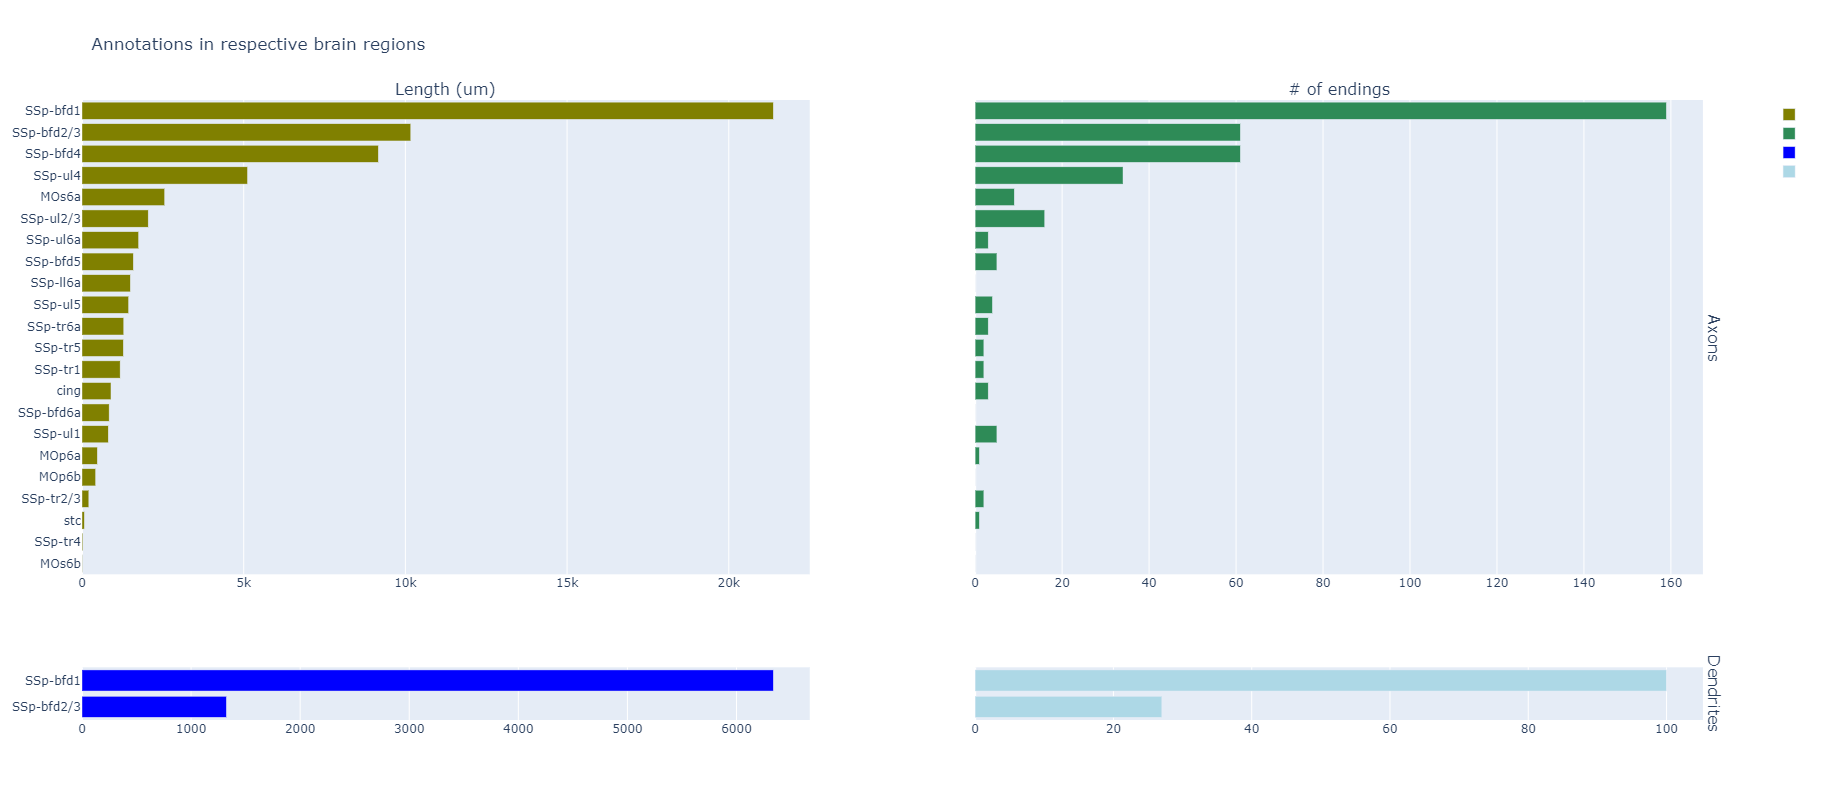

In [280]:
plot_hist(axons, dendrites, outdir, name)

### now plots the full resolution points in 3D scatter

In [ ]:
ori_points_name=fdialog.askopenfile( title='Select the converted&resampled origional points').name

In [305]:
def findID_origional(origional_points, points_in_atlas):
    '''
    Associate origional converted resampled points with atlas ID and name
    Ouputs a pd dataframe with x, y, z, atlas ID, region name, colour
    '''
    #Load the origional points
    anno=open(origional_points,'r')
    anno_data=anno.readlines()
    # heading is stored in anno_data[2], 1st line basically useless

    headings=anno_data[2].rstrip('\n').replace(' ', '').split(',')
    annotations=[lines.rstrip('0 1\n').split(' ') for lines in anno_data[3:]]
    #slight modification on replacing and stripping due to the format of the resampled swc
    annotation_df=pd.DataFrame(annotations, columns=headings)

    points_with_id= pd.DataFrame (zip(annotation_df['x'],annotation_df['y'], annotation_df['z'],points_in_atlas ), columns=['x', 'y','z', 'atlasID'])
    #points_with_id.to_csv (outdir+'/resamp_oripoints_withID.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path
    
    #Creates colour for each region
    uniqueID=np.unique(points_with_id['atlasID'])
    colour= np.linspace(1,np.size(uniqueID)+1, num=np.size(uniqueID),dtype='int')
    colourdict=dict(zip(uniqueID,colour))
    
    # find region name based on ID
    namedict=dict(zip(atlas_labels['id'],atlas_labels['name']))
    points_with_id['name'] = points_with_id['atlasID'].map(namedict)
    points_with_id['colour'] = points_with_id['atlasID'].map(colourdict)
    return points_with_id

In [365]:
def make_scatter(points_with_id, ending_indices):
    
    ending_indices = np.genfromtxt(ending_indices, delimiter=',', dtype='int')
    
    trace= go.Scatter3d( 
        x=points_with_id[::3]['x'],
        y=points_with_id[::3]['y'],
        z=points_with_id[::3]['z'],
        mode='markers',
        name='Non-endings',
        marker=dict(
            size=1,
            color=points_with_id[::3]['colour'],
            opacity=0.5
        ),
        hovertext= points_with_id[::3]['name'],
        hoverinfo='text'
    )

    layout=go.Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0)
    )
    
    trace_endings=go.Scatter3d(
        x=points_with_id.iloc[ending_indices]['x'],
        y=points_with_id.iloc[ending_indices]['y'],
        z=points_with_id.iloc[ending_indices]['z'],
        mode='markers',
        name='Endings',
        marker=dict(
            size=2,
            color=points_with_id.iloc[ending_indices]['colour'],
            opacity=0.5,
            symbol='diamond')
    )

#Here we want horizontal view with dorsal surface toward us
#first we set a xz view for coronal section this is done by setting x and z as 0 in eye
# then, for y we want the smaller values to point toward us (because in our original coronal images dorsal surface is pointed up)
    camera = dict(
        eye=dict(x=0, y=-1, z=0)
    )


    #Need to change the axis title depending on the direction and orientation of the origional image (ie, imaging started from cerebellum vs. imaging started from olfactorybulb)
    fig=go.Figure(data=trace,layout=layout)
    fig.update_layout(scene_camera=camera, 
                      scene=dict(
                        xaxis_title='Smaller=more medial',
                        yaxis_title='Smaller=more dorsal',
                        zaxis_title='Smaller=more anterior'))
    plot(fig,filename=outdir+'/'+'3Dplot.html')
    

In [310]:
axonal_points_with_id= findID_origional(ori_points_name, axonal_points_in_atlas)

In [366]:
make_scatter(axonal_points_with_id,outdir+'/'+ axon_ending[0] )